In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
cwd = os.getcwd()
base_path = os.path.abspath(os.path.join(cwd, '../../'))

## Fig.5 Integrative regulatory inference by model interpretability and pseudo-knockout

- Heatmap of attention matrix between RNA and protein.

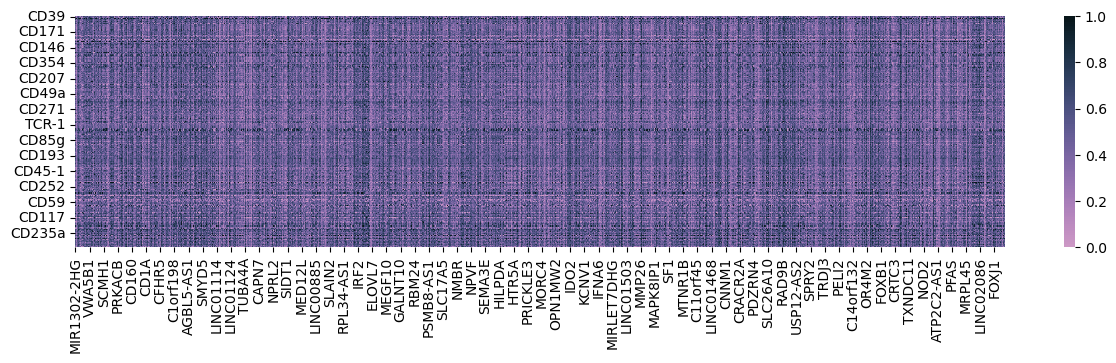

In [2]:
path = base_path+'/result/fig5/a/encoder2decoder_attention_score.csv'
weights = pd.read_csv(path, sep=',',index_col=0)

fig = plt.figure(figsize=(15,3))
color = sns.cubehelix_palette(16,start=2.5, rot=0.5, gamma=.9, dark=0.05, light=0.65, as_cmap=True)
sns.heatmap(weights.T, cmap=color)
plt.show()

- zoom in attention matrix obtained from encoder to decoder 

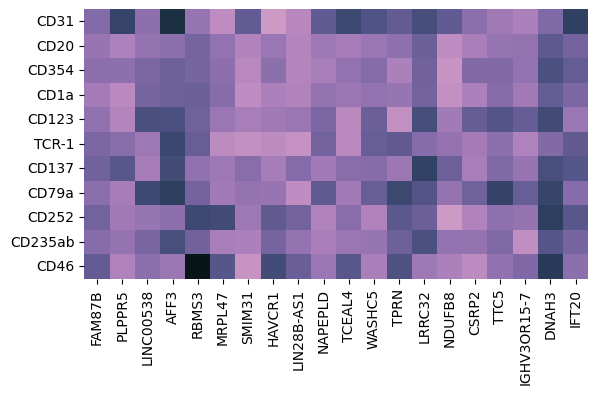

In [3]:
fig = plt.figure(figsize=(6.5,3.5))
n_g = 1000
n_p = 20
# sns.heatmap(weights.iloc[::n_g,::n_p].T, cmap=color, cbar=False)
sns.heatmap(weights.iloc[5::n_g,5::n_p].T, cmap=color, cbar=False)
plt.show()

- Potential regulation gene

In [4]:
percent = 0.05
regulation_gene = weights.sum(axis=1).sort_values(ascending=False).index[:int(weights.shape[0]*percent)]

- GRN

In [5]:
path = os.path.join(base_path, 'result/fig5/a/encoder_attention_score.csv')
enc_weights = pd.read_csv(path, sep=',', index_col=0)

target_proteins = ['STAT3', 'IRF4', 'FOXP3']

result_list = []
for protein in target_proteins:
    enc_weights_filtered = enc_weights.drop(columns=protein, errors='ignore')
    top_genes = enc_weights_filtered.loc[protein,:].nlargest(20)
    for gene, score in top_genes.items():
        result_list.append([protein, gene, score])
        
result_df = pd.DataFrame(result_list, columns=['TF', 'Gene', 'Attention Score'])
path = os.path.join(base_path, 'result/fig5/c/GRN.xlsx')
result_df.to_excel(path, index=False)
print(result_df)

       TF        Gene  Attention Score
0   STAT3        ODF3         1.000000
1   STAT3     SLC30A6         0.909990
2   STAT3       EXOC2         0.835076
3   STAT3     CCDC189         0.810703
4   STAT3       VAMP1         0.801102
5   STAT3   LINC02378         0.792640
6   STAT3      ARL17B         0.748191
7   STAT3       REG1A         0.747889
8   STAT3        FLT4         0.724389
9   STAT3     DCSTAMP         0.723804
10  STAT3       TTLL4         0.715181
11  STAT3       ESRRB         0.707988
12  STAT3      TRIM42         0.705961
13  STAT3       TONSL         0.702463
14  STAT3       OR9G1         0.696760
15  STAT3       SRPRB         0.696497
16  STAT3         CGN         0.694542
17  STAT3       PTRH2         0.690507
18  STAT3       RAMP3         0.687157
19  STAT3       MKRN1         0.686604
20   IRF4        SOX1         1.000000
21   IRF4     PHACTR1         0.951936
22   IRF4        GNLY         0.934286
23   IRF4       ZZEF1         0.928173
24   IRF4      ZBTB22    

## PPI

In [6]:
path = os.path.join(base_path, 'result/fig5/a/decoder_attention_score.csv')
dec_weights = pd.read_csv(path, sep=',', index_col=0)

target_proteins = ['CD8a', 'CD273', 'CD45RA']

result_list = []
for protein in target_proteins:
    dec_weights_filtered = dec_weights.drop(columns=protein, errors='ignore')
    top_genes = dec_weights_filtered.loc[protein,:].nlargest(23)
    for gene, score in top_genes.items():
        result_list.append([protein, gene, score])
        
result_df = pd.DataFrame(result_list, columns=['Protein A', 'Protein B', 'Attention Score'])
path = os.path.join(base_path, 'result/fig5/d/PPI.xlsx')
result_df.to_excel(path, index=False)
print(result_df)


   Protein A  Protein B  Attention Score
0       CD8a       CD1c         1.000000
1       CD8a      CD271         1.000000
2       CD8a       CD80         1.000000
3       CD8a      CD338         0.987884
4       CD8a       CD68         0.881016
..       ...        ...              ...
64    CD45RA       CD69         0.769143
65    CD45RA  TCR-V-7.2         0.767565
66    CD45RA      CD206         0.763793
67    CD45RA      B7-H4         0.762812
68    CD45RA     CD56-1         0.761120

[69 rows x 3 columns]


## Effects of gene knock out

In [7]:
import torch
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from torch.nn import CosineSimilarity

def normalization(x, low=1e-8, high=1):
    MIN = min(x)
    MAX = max(x)
    if MIN == MAX:
        return np.zeros_like(x)
    x = low + (x - MIN) / (MAX - MIN) * (high - low)
    return x

def calculate_metrics(y_pred, y_truth):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_pred_tensor = torch.tensor(y_pred).to(device)
    y_truth_tensor = torch.tensor(y_truth).to(device)
    
    cosine_sim_list = []
    pearson_list = []
    cos = CosineSimilarity(dim=1)
    for i in range(len(y_pred)):
        cosine_sim = cos(y_truth_tensor[i].unsqueeze(0), y_pred_tensor[i].unsqueeze(0))
        pearson = pearsonr(y_truth_tensor[i].cpu().numpy(), y_pred_tensor[i].cpu().numpy())[0]
        cosine_sim_list.append(cosine_sim.item())
        pearson_list.append(pearson)
    
    return cosine_sim_list, pearson_list

In [8]:
base_path = base_path + r'/dataset/test/perturb cite-seq/'

path = base_path + r'perturbed_FrangiehIzar2021_protein.h5ad'
pro_adata = sc.read(path)
pro_adata.var.set_index("Target", inplace=True)
normalized_matrix = np.apply_along_axis(normalization, axis=1, arr=pro_adata.X)
pro_adata.X = normalized_matrix

path = base_path + r'pred_perturbed_FrangiehIzar2021_protein.h5ad'
pred_perturbed_pro_adata = sc.read(path)
pred_perturbed_pro_adata.var.set_index("Target", inplace=True)

gene_knocked = ['STAT1', 'JAK1', 'JAK2', 'IFNGR1', 'IFNGR2']
pro_list = ['HLA-ABC', 'CD274', 'CD47', 'CD9 ', 'CD59', 'CD58']
data = []
metrics = ["Cosine similarity", "Pearson correlation"]
for gene in gene_knocked:
    perturbed_adata_truth = pro_adata[pro_adata.obs.perturbation == gene, pro_list].X.copy()
    perturbed_adata_pred = pred_perturbed_pro_adata[pred_perturbed_pro_adata.obs.perturbation == gene, pro_list].X.copy()
    cosine_sim_list, pearson_list = calculate_metrics(perturbed_adata_pred, perturbed_adata_truth)
    values = [cosine_sim_list, pearson_list]
    for metric, value_list in zip(metrics, values):
        for value in value_list:
            data.append({"gene": gene, "metrics": metric, "value": value})
df = pd.DataFrame(data)

<Figure size 800x600 with 0 Axes>

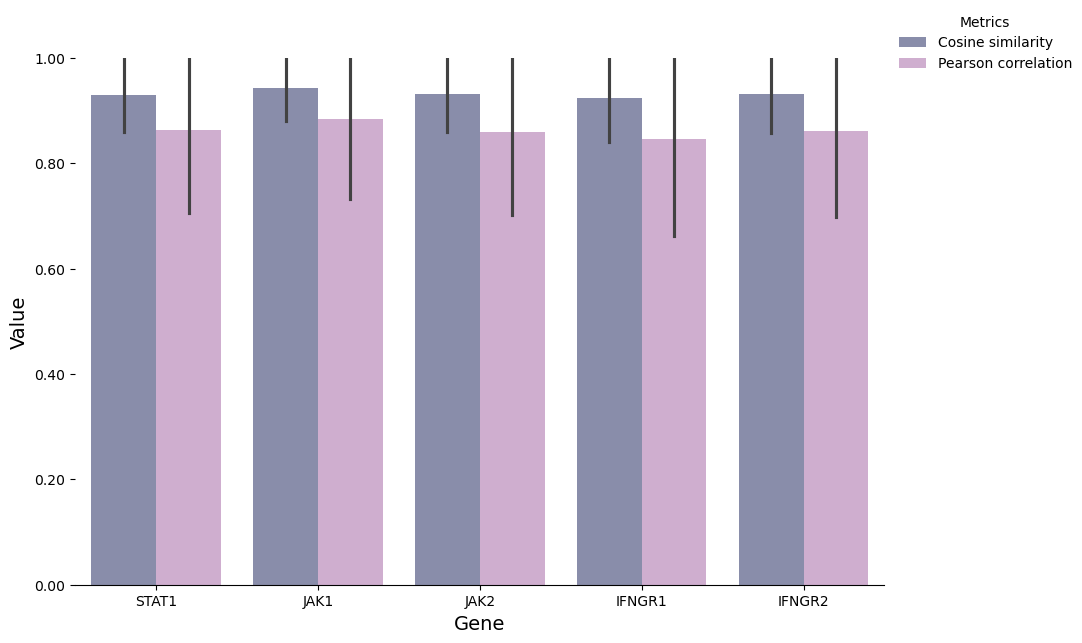

In [9]:

custom_palette = {"Cosine similarity": "#8389AF", "Pearson correlation": "#D4A8D5"}
filtered_df = df[df.metrics.isin(["Cosine similarity", "Pearson correlation"])]
plt.figure(figsize=(8, 6))
g = sns.catplot(
    data=filtered_df, kind="bar",
    x="gene", y="value", hue="metrics",
    errorbar="sd", palette=custom_palette,
    height=6, aspect=1.5
)

g.ax.set_ylim(0.0, 1)
g.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))

g.ax.set_ylabel("Value", fontsize=14)
g.ax.set_xlabel("Gene", fontsize=14)
g._legend.set_title("Metrics")
g._legend.set_bbox_to_anchor((1, 1))
g.despine(left=True)
plt.show()

Generating plots for gene: STAT1
num of control: (12258, 3)
num of perturbed: (347, 3)
u_stat for  HLA-ABC 3793421.0
u_stat for  CD274 2926353.0
u_stat for  CD47 3309259.0


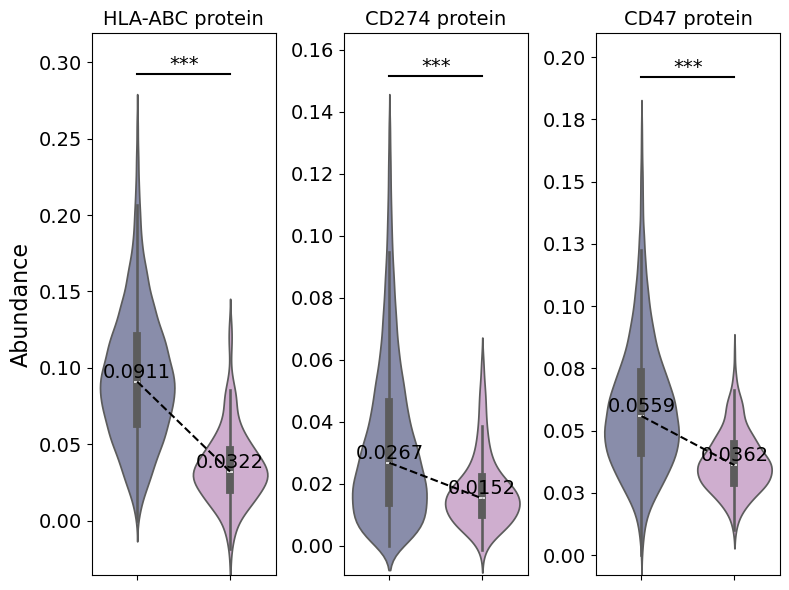

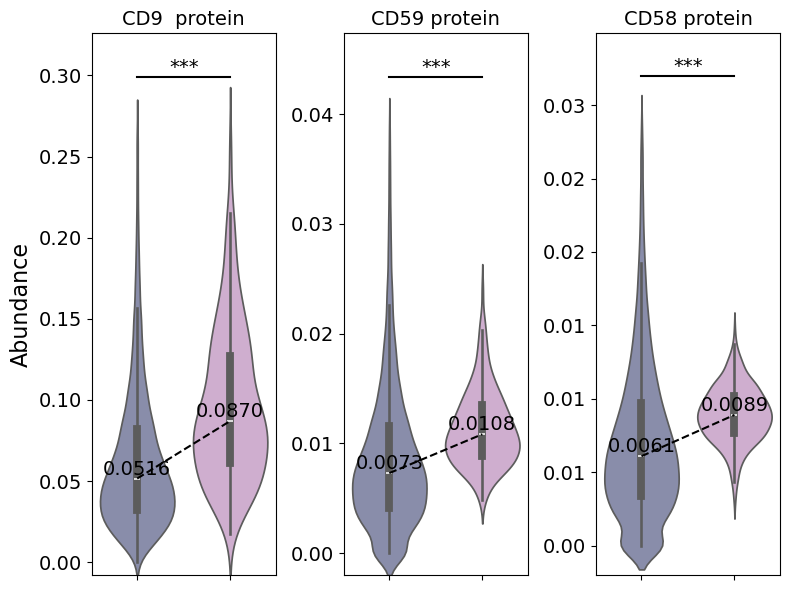

Generating plots for gene: JAK1
num of control: (12258, 3)
num of perturbed: (347, 3)
u_stat for  HLA-ABC 3654898.0
u_stat for  CD274 2860677.0
u_stat for  CD47 3234236.0


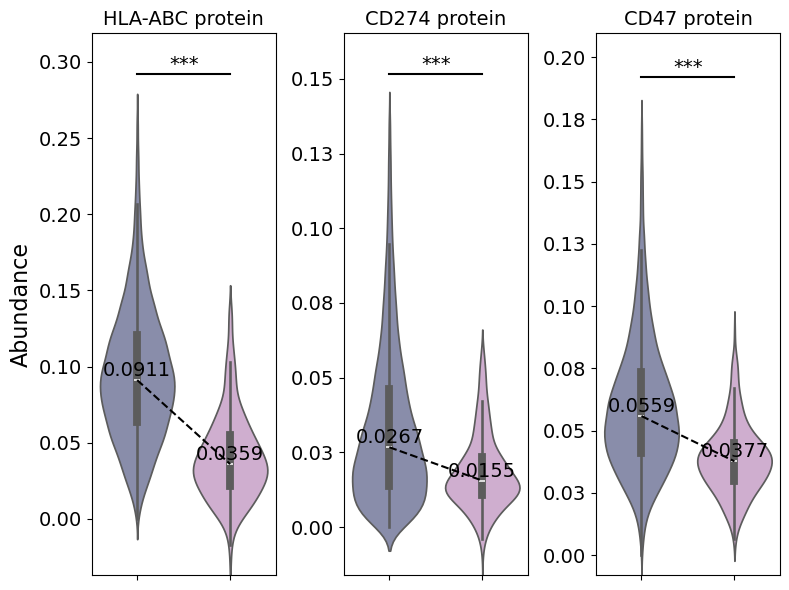

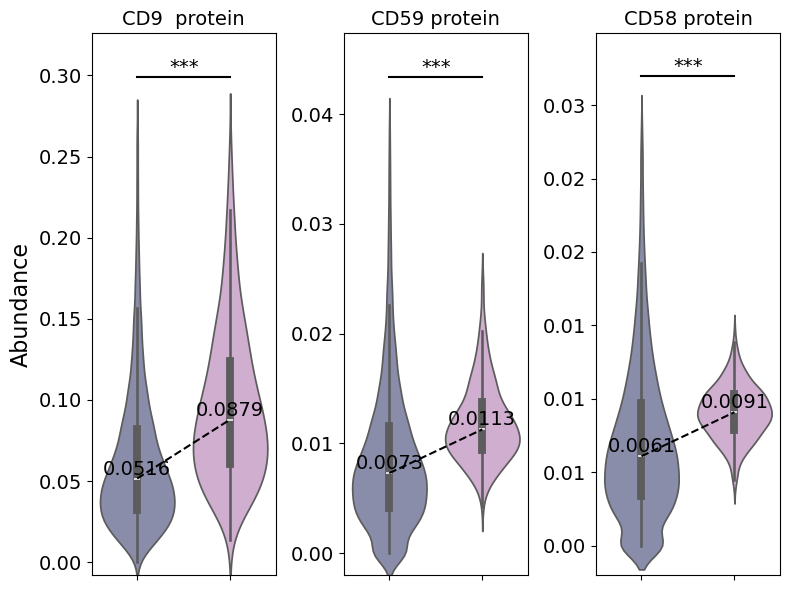

Generating plots for gene: JAK2
num of control: (12258, 3)
num of perturbed: (392, 3)
u_stat for  HLA-ABC 4091172.0
u_stat for  CD274 3180107.0
u_stat for  CD47 3601956.0


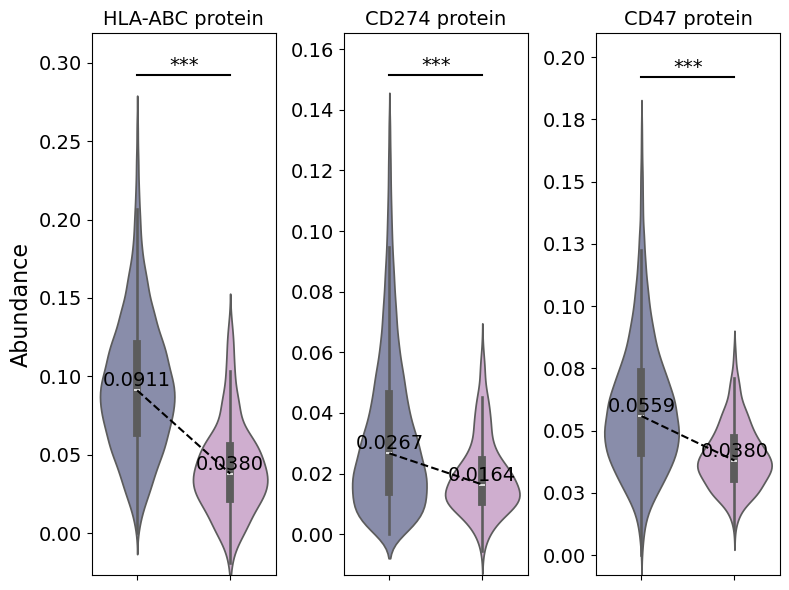

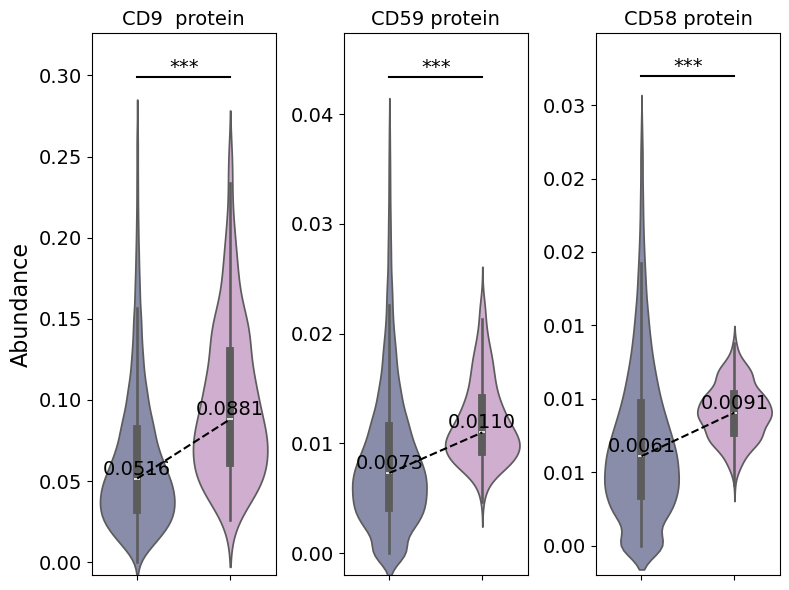

Generating plots for gene: IFNGR1
num of control: (12258, 3)
num of perturbed: (281, 3)
u_stat for  HLA-ABC 2934407.0
u_stat for  CD274 2353027.0
u_stat for  CD47 2588133.0


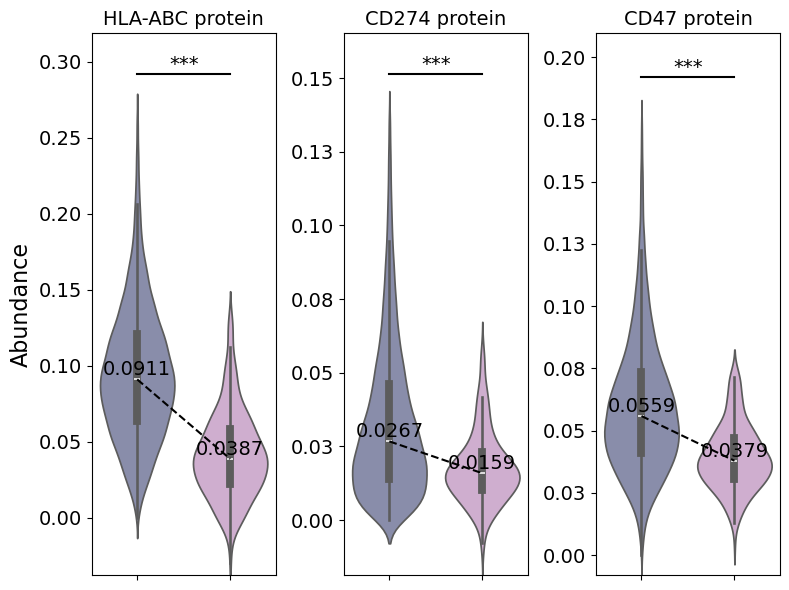

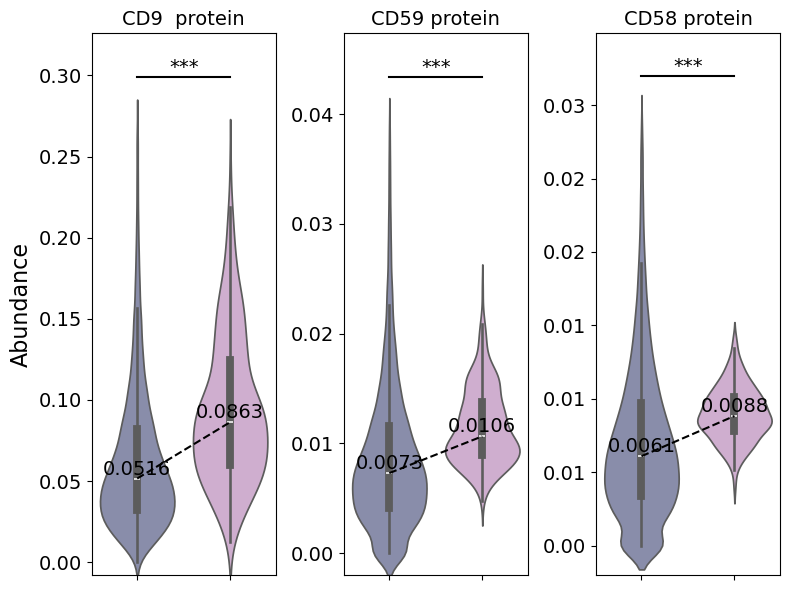

Generating plots for gene: IFNGR2
num of control: (12258, 3)
num of perturbed: (420, 3)
u_stat for  HLA-ABC 4314619.0
u_stat for  CD274 3499912.0
u_stat for  CD47 3778235.0


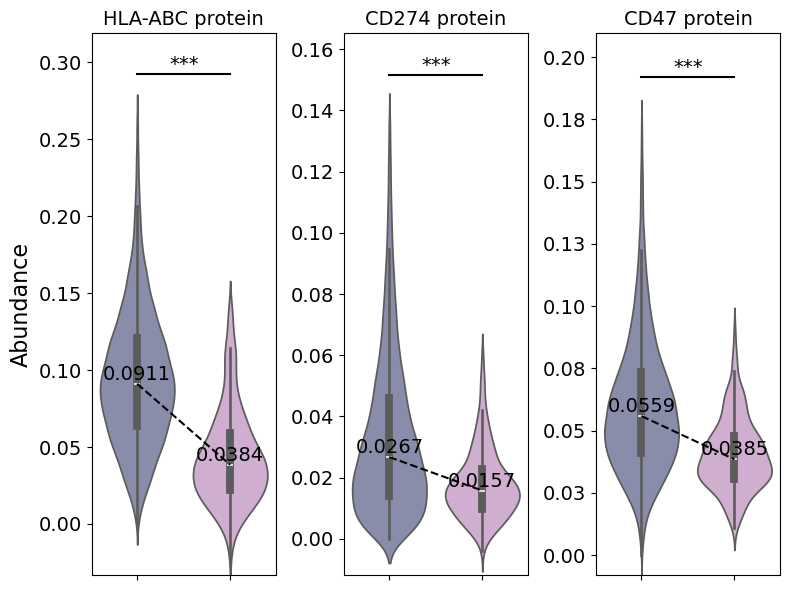

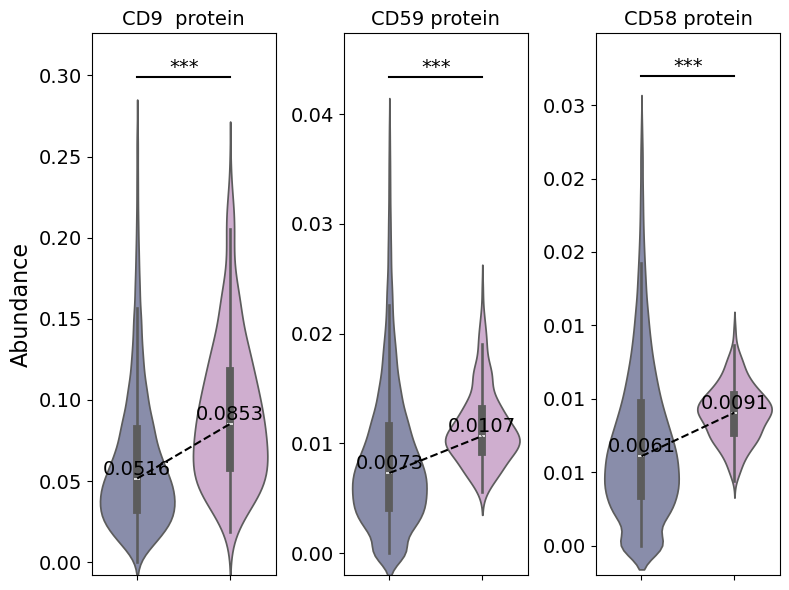

In [10]:
from scipy import stats
from scipy.stats import mannwhitneyu

path = base_path + 'norm_control_FrangiehIzar2021_protein.h5ad'
pro_adata = sc.read(path)
pro_adata.var.set_index("Target", inplace=True)


path = base_path + 'pred_perturbed_FrangiehIzar2021_protein.h5ad'
pred_perturbed_pro_adata = sc.read(path)
pred_perturbed_pro_adata.var.set_index("Target", inplace=True)

# Define the list of genes that were knocked out and proteins of interest
gene_knocked = ['STAT1', 'JAK1', 'JAK2', 'IFNGR1', 'IFNGR2']
proteins_of_interest_downregulated = ['HLA-ABC', 'CD274', 'CD47']
proteins_of_interest_upregulated = ['CD9 ', 'CD59', 'CD58']

# Function to filter out outliers based on z-scores
def filter_outliers(df, threshold=3):
    """
    Filters out rows in the DataFrame where any protein value has a z-score greater than the threshold.
    """
    z_scores = np.abs(stats.zscore(df, axis=0, nan_policy='omit'))  # Calculate z-scores for each column (protein)
    return df[(z_scores < threshold).all(axis=1)]  # Keep rows where all proteins have z-scores less than the threshold

# Custom color palette
custom_palette = {"Control": "#8389AF", "Perturbed": "#D4A8D5"}

def plot_violin(df, proteins, p_values, perturbed_label, output_prefix):
    """
    Function to plot violin plots with significance stars and mean values for Control and Perturbed groups,
    and save the plots as PNG and SVG files.
    """
    # Ensure that the color palette contains the perturbation label
    custom_palette.setdefault(perturbed_label, "#D4A8D5")

    plt.figure(figsize=(8, 6))  # Set figure size

    for idx, protein in enumerate(proteins):
        ax = plt.subplot(1, len(proteins), idx + 1)

        # Plot the violin plot
        sns.violinplot(x=df.index.get_level_values(0), y=df[protein], ax=ax, palette=custom_palette)
        ax.set_title(f'{protein} protein', fontsize=14)
        ax.set_ylabel('Abundance', fontsize=16)
        ax.set_ylim(min(df[protein]) - 0.008, max(df[protein]) * 1.2)
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.2f}'))
        ax.set_xlabel('')  

        # Adjust y-axis limits
        ax.set_ylim(min(df[protein]) - 0.008, max(df[protein]) * 1.2)
        if idx in [1,2]:
            ax.set_ylabel('')  
            if "upregulated" in output_prefix:
                ax.set_ylim(min(df[protein]) - 0.002, max(df[protein]) * 1.2)

        ax.set_xticklabels([])
        ax.tick_params(axis='y', labelsize=14)
        # Add stars for significance based on p-value
        p_val = p_values[protein]
        if p_val < 0.001:
            ax.text(0.5, max(df[protein])* 1.1, '***', ha='center', va='bottom', fontsize=14)
        elif p_val < 0.01:
            ax.text(0.5, max(df[protein]), '**', ha='center', va='bottom', fontsize=14)
        elif p_val < 0.05:
            ax.text(0.5, max(df[protein]), '*', ha='center', va='bottom', fontsize=14)
        ax.plot([0, 1], [max(df[protein])* 1.1, max(df[protein])* 1.1], color='black', linestyle='-')

        # Plot median as dashed lines
        control_median = np.median(df.loc['Control', protein])
        perturbed_median = np.median(df.loc[perturbed_label, protein])
        ax.plot([0, 1], [control_median, perturbed_median], color='black', linestyle='--')

        # Add mean value annotations
        ax.text(0, control_median, f'{control_median:.4f}', ha='center', va='bottom', fontsize=14, color='black')
        ax.text(1, perturbed_median, f'{perturbed_median:.4f}', ha='center', va='bottom', fontsize=14, color='black')



    plt.tight_layout()
    plt.show()

# Loop through each gene knocked out to create separate plots
for gene in gene_knocked:  # Modify the slice to generate plots for other genes
    print(f"Generating plots for gene: {gene}")

    # Extract the relevant data for each gene knockdown
    control_adata_gene = pro_adata[pro_adata.obs.perturbation == 'control', :]
    perturbed_adata_gene = pred_perturbed_pro_adata[pred_perturbed_pro_adata.obs.perturbation == gene, :]
    control_protein_data_downregulated = control_adata_gene[:, proteins_of_interest_downregulated].X
    control_protein_data_upregulated = control_adata_gene[:, proteins_of_interest_upregulated].X
    perturbed_protein_data_downregulated = perturbed_adata_gene[:, proteins_of_interest_downregulated].X
    perturbed_protein_data_upregulated = perturbed_adata_gene[:, proteins_of_interest_upregulated].X
    control_df_downregulated = pd.DataFrame(control_protein_data_downregulated, columns=proteins_of_interest_downregulated)
    control_df_upregulated = pd.DataFrame(control_protein_data_upregulated, columns=proteins_of_interest_upregulated)
    perturbed_df_downregulated = pd.DataFrame(perturbed_protein_data_downregulated, columns=proteins_of_interest_downregulated)
    perturbed_df_upregulated = pd.DataFrame(perturbed_protein_data_upregulated, columns=proteins_of_interest_upregulated)

    # Apply outlier filtering to both control and perturbed groups
    control_df_downregulated_filtered = filter_outliers(control_df_downregulated)
    control_df_upregulated_filtered = filter_outliers(control_df_upregulated)
    perturbed_df_downregulated_filtered = filter_outliers(perturbed_df_downregulated)
    perturbed_df_upregulated_filtered = filter_outliers(perturbed_df_upregulated)
    print('num of control:', control_df_downregulated_filtered.shape)
    print('num of perturbed:', perturbed_df_downregulated_filtered.shape)

    # Dynamically handle perturbed label formatting
    perturbed_label = f'{gene} Perturbed'.strip()
    

    # Concatenate the control and perturbed data
    combined_df_downregulated_filtered = pd.concat([control_df_downregulated_filtered, perturbed_df_downregulated_filtered], keys=['Control', perturbed_label])
    combined_df_upregulated_filtered = pd.concat([control_df_upregulated_filtered, perturbed_df_upregulated_filtered], keys=['Control', perturbed_label])

    # Perform t-tests for significance
    p_values_downregulated = {}
    p_values_upregulated = {}

    # Downregulated proteins t-test
    for protein in proteins_of_interest_downregulated:
        u_stat, p_val = mannwhitneyu(control_df_downregulated_filtered[protein], perturbed_df_downregulated_filtered[protein], alternative='two-sided')
        p_values_downregulated[protein] = p_val
        print('u_stat for ', protein, u_stat)

    # Upregulated proteins t-test
    for protein in proteins_of_interest_upregulated:
        u_stat, p_val = mannwhitneyu(control_df_upregulated_filtered[protein], perturbed_df_upregulated_filtered[protein], alternative='two-sided')
        p_values_upregulated[protein] = p_val
    plot_violin(combined_df_downregulated_filtered, proteins_of_interest_downregulated, p_values_downregulated, perturbed_label, f"{gene}_downregulated")
    plot_violin(combined_df_upregulated_filtered, proteins_of_interest_upregulated, p_values_upregulated, perturbed_label, f"{gene}_upregulated")